In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from PyHa.annotation_post_processing import annotation_chunker
from PyHa.template_matching.utils import generate_specgram, butter_bandpass, filter
import librosa
import os
import matplotlib.pyplot as plt
import math
import random

In [2]:
isolation_parameters = {
    "model" : "template_matching",
    # we will be modifying this for each path
    "template_path" : "",
    "technique" : "steinberg",
    # ideally this is the length of the template in seconds
    "window_size" : 0.6,
    "threshold_type" : "pure",
    "threshold_const" : 0.20,
    "cutoff_freq_low" : 1000,
    "cutoff_freq_high" : 2000,
    "verbose" : True,
    "write_confidence" : True
}
# creating the bandpass filter
b, a = butter_bandpass(isolation_parameters['cutoff_freq_low'], 
                       isolation_parameters['cutoff_freq_high'], 8000, order=10)

In [3]:
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier

def train_ensemble(x, y):
    # initializing the shallow learning models
    model_dict = {
        "lsvm" : LinearSVC(),
        "rsvm" : svm.SVC(kernel='rbf'),
        "knn"  : KNeighborsRegressor(weights='distance'),
        "rf"   : RandomForestClassifier(),
        "lreg" : LogisticRegression()
    }
    # training the models
    model_dict["lsvm"].fit(x,y)
    model_dict["rsvm"].fit(x,y)
    model_dict["knn"].fit(x,y)
    model_dict["rf"].fit(x,y)
    model_dict["lreg"].fit(x,y)
    
    return model_dict

def generate_data(df, b, a):
    x = []
    y = []
    for row in df.index:
        cur_path = os.path.join(df["FOLDER"][row], df["IN FILE"][row])
        cur_id = df["MANUAL ID"][row]
        cur_offset = df["OFFSET"][row]
        sr = df["SAMPLE RATE"][row]
        duration = df["DURATION"][row]
        if cur_offset > 59:
            cur_clip, _ = librosa.load(cur_path, sr=sr, offset=cur_offset, duration=duration)
            repeat_count = math.ceil(sr/len(cur_clip))
            cur_clip = np.repeat(cur_clip, repeat_count)[0:sr]
        else:
            cur_clip, _ = librosa.load(cur_path, sr=sr, offset=cur_offset, duration=1.0)

        cur_clip = filter(cur_clip, b, a)
        cur_mel_spec = librosa.feature.melspectrogram(y=cur_clip, sr=sr)
        cur_mel_spec = cur_mel_spec.flatten()
        x.append(cur_mel_spec)
        if cur_id == "CP_1":
            y.append(1)
        else:
            y.append(0)
    return np.array(x), np.array(y)

def ensemble_predict(x, models):
    predictions = np.zeros((x.shape[0],))
    for model in models.keys():
        predictions += models[model].predict(x)
    return predictions

In [4]:
def tp_fp_counts(df):
    tp_count = len(df[df["MANUAL ID"]=="CP_1"])
    fp_count = len(df[df["MANUAL ID"]=="CP_0"])
    return tp_count, fp_count

In [5]:
poorwill_df = pd.read_csv("Poorwill_Scripps_Full_Labeled.csv")
total_tp_count, total_fp_count = tp_fp_counts(poorwill_df)
template_output_count = len(poorwill_df)
print("Template Matching Output Count w/ Confidence threshold 0.2 - ", template_output_count)
print("True Positive Count - ", total_tp_count)
print("False Positive Count - ", total_fp_count)
print("Precision - ", round(total_tp_count/(total_tp_count+total_fp_count),4))

Template Matching Output Count w/ Confidence threshold 0.2 -  677
True Positive Count -  391
False Positive Count -  286
Precision -  0.5775


In [6]:
# freezing randomness for reproducibility
random.seed(0)
np.random.seed(0)
label_counts = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
# ordering the dataframe based on template confidence values (ascending order)
poorwill_df = poorwill_df.sort_values("CONFIDENCE")

## Experiment 1 - Randomly Labeling Data

In [7]:
exp1_tp_rate = []
for label_count in label_counts:
    #label_indices = random.sample( range(template_output_count), label_count)
    labeled_df = poorwill_df.sample(n=label_count)
    cur_tp_count, cur_fp_count = tp_fp_counts(labeled_df)
    exp1_tp_rate.append(cur_tp_count/total_tp_count)

## Experiment 2 - Labeling the Top Correlation Values

In [8]:
exp2_tp_rate = []
for label_count in label_counts:
    labeled_df = poorwill_df.tail(label_count)
    
    cur_tp_count, cur_fp_count = tp_fp_counts(labeled_df)
    exp2_tp_rate.append(cur_tp_count/total_tp_count)
    

## Experiment 3 - Training Ensemble on Random Selection 20-80 

In [9]:
exp3_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    train_df = poorwill_df.sample(int(label_count * 0.2))
    # Creating 
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.8))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp3_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 4 - Training Ensemble on High-low Confidence Split 20-80

In [10]:
exp4_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    high_conf_df = poorwill_df.tail(int(label_count*0.1))
    low_conf_df = poorwill_df.head(int(label_count*0.1))
    train_df = pd.concat([high_conf_df, low_conf_df])
    
    # Unlabeled dataset full
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.8))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp4_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 5 - Training Ensemble on High-low Confidence Split and some Random Selections 20-80

In [11]:
exp5_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    
    high_conf_df = poorwill_df.tail(int(label_count*0.07))
    low_conf_df = poorwill_df.head(int(label_count*0.07))
    random_df = pd.concat([poorwill_df, high_conf_df, low_conf_df]).drop_duplicates(keep=False).sample(int(label_count*0.06))
    train_df = pd.concat([high_conf_df, low_conf_df, random_df])
    
    # Unlabeled dataset full
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.8))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp5_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 6 - Training Ensemble on Random Selection 50-50 

In [12]:
exp6_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    train_df = poorwill_df.sample(int(label_count * 0.5))
    # Creating 
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.5))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp6_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 7 - Training Ensemble on High-low Confidence Split 50-50

In [13]:
exp7_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    high_conf_df = poorwill_df.tail(int(label_count*0.25))
    low_conf_df = poorwill_df.head(int(label_count*0.25))
    train_df = pd.concat([high_conf_df, low_conf_df])
    
    # Unlabeled dataset full
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.5))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp7_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 8 - Training Ensemble on High-low Confidence Split and some Random Selections 50-50

In [14]:
exp8_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    
    high_conf_df = poorwill_df.tail(int(label_count*0.17))
    low_conf_df = poorwill_df.head(int(label_count*0.17))
    random_df = pd.concat([poorwill_df, high_conf_df, low_conf_df]).drop_duplicates(keep=False).sample(int(label_count*0.16))
    train_df = pd.concat([high_conf_df, low_conf_df, random_df])
    
    # Unlabeled dataset full
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.5))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp8_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 9 - Training Ensemble on Random Selection 10-90 

In [15]:
exp9_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    train_df = poorwill_df.sample(int(label_count * 0.1))
    # Creating 
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.9))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp9_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 10 - Training Ensemble on High-low Confidence Split 10-90

In [20]:
exp10_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    high_conf_df = poorwill_df.tail(int(label_count*0.05))
    low_conf_df = poorwill_df.head(int(label_count*0.05))
    train_df = pd.concat([high_conf_df, low_conf_df])
    
    # Unlabeled dataset full
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.9))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp10_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 11 - Training Ensemble on High-low Confidence Split and some Random Selections 10-90

In [27]:
exp11_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    
    high_conf_df = poorwill_df.tail(int(label_count*0.035))
    low_conf_df = poorwill_df.head(int(label_count*0.035))
    random_df = pd.concat([poorwill_df, high_conf_df, low_conf_df]).drop_duplicates(keep=False).sample(int(label_count*0.03))
    train_df = pd.concat([high_conf_df, low_conf_df, random_df])
    
    # Unlabeled dataset full
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.9))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp11_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 12 - Training Ensemble on Random Selection 30-70 

In [22]:
exp12_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    train_df = poorwill_df.sample(int(label_count * 0.3))
    # Creating 
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.7))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp12_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 13 - Training Ensemble on High-low Confidence Split 30-70

In [23]:
exp13_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    high_conf_df = poorwill_df.tail(int(label_count*0.15))
    low_conf_df = poorwill_df.head(int(label_count*0.15))
    train_df = pd.concat([high_conf_df, low_conf_df])
    
    # Unlabeled dataset full
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.7))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp13_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

## Experiment 14 - Training Ensemble on High-low Confidence Split and some Random Selections 30-70

In [25]:
exp14_tp_rate = []
for label_count in label_counts:
    # Creating an ensemble model training set
    
    high_conf_df = poorwill_df.tail(int(label_count*0.1))
    low_conf_df = poorwill_df.head(int(label_count*0.1))
    random_df = pd.concat([poorwill_df, high_conf_df, low_conf_df]).drop_duplicates(keep=False).sample(int(label_count*0.1))
    train_df = pd.concat([high_conf_df, low_conf_df, random_df])
    
    # Unlabeled dataset full
    test_pool_df = pd.concat([poorwill_df, train_df])
    test_pool_df = test_pool_df.drop_duplicates(keep=False)
    
    train_x, train_y = generate_data( train_df, b, a)
    models = train_ensemble(train_x, train_y)

    test_pool_x, test_pool_y = generate_data(test_pool_df, b, a)
    
    predictions = ensemble_predict(test_pool_x, models)
    test_pool_df["ENSEMBLE VOTE"] = predictions
    test_pool_df = test_pool_df.sort_values("ENSEMBLE VOTE")
    test_df = test_pool_df.tail(int(label_count * 0.7))

    train_tp_count, train_fp_count = tp_fp_counts(train_df)
    test_tp_count, test_fp_count = tp_fp_counts(test_df)

    cur_tp_count = train_tp_count + test_tp_count
    
    exp14_tp_rate.append(cur_tp_count/total_tp_count)
    

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

Text(0.5, 1.0, 'True Positives Identified vs. Amount of Data Labeled\n Species: Common Poorwill \n n=677')

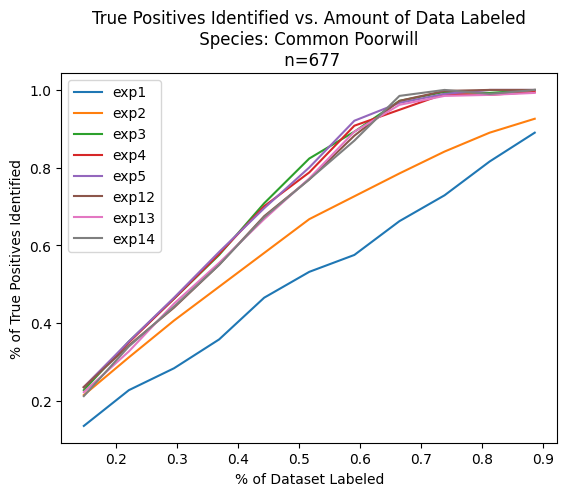

In [29]:
## TODO - Add in "ideal"
percent_counts = np.array(label_counts)/template_output_count
plt.figure()
plt.plot(percent_counts, exp1_tp_rate, label="exp1")
plt.plot(percent_counts, exp2_tp_rate, label="exp2")
# 20-80
plt.plot(percent_counts, exp3_tp_rate, label="exp3")
plt.plot(percent_counts, exp4_tp_rate, label="exp4")
plt.plot(percent_counts, exp5_tp_rate, label="exp5")
# 50-50
#plt.plot(percent_counts, exp6_tp_rate, label="exp6")
#plt.plot(percent_counts, exp7_tp_rate, label="exp7")
#plt.plot(percent_counts, exp8_tp_rate, label="exp8")
# 10-90
#plt.plot(percent_counts, exp9_tp_rate, label="exp9")
#plt.plot(percent_counts, exp10_tp_rate, label="exp10")
#plt.plot(percent_counts, exp11_tp_rate, label="exp11")
# 30-70
plt.plot(percent_counts, exp12_tp_rate, label="exp12")
plt.plot(percent_counts, exp13_tp_rate, label="exp13")
plt.plot(percent_counts, exp14_tp_rate, label="exp14")
plt.legend()
plt.ylabel("% of True Positives Identified")
plt.xlabel("% of Dataset Labeled")
plt.title("True Positives Identified vs. Amount of Data Labeled\n Species: Common Poorwill \n n=677")